In [1]:
import emcee
import matplotlib.pyplot as plt
import pyccl as ccl
import numpy as np
import corner
from IPython.display import display, Math
import seaborn as sns
import matplotlib.colors as mcolors

print(emcee.__version__)

3.1.6


In [ ]:
#print(ccl.comoving_radial_distance(cosmo_universe, 1/1.4) - ccl.comoving_radial_distance(cosmo_universe, 1/1.1))
#print(605*np.pi**2/180**2 * ccl.comoving_radial_distance(cosmo_universe, 1/1.55)**2 * (ccl.comoving_radial_distance(cosmo_universe, 1/1.4) - ccl.comoving_radial_distance(cosmo_universe, 1/1.1)) * cosmo_universe["h"]**3)

In [2]:
# Define cosmology

cosmo_universe = ccl.Cosmology(Omega_c = 0.269619, 
                          Omega_b = 0.050041,
                          h = 0.6688,
                          n_s = 0.9626,
                          A_s = 2.092e-9)

Bias_distribution_fiducial = np.array([1.562362,
                             1.732963,
                             1.913252,
                             2.100644,
                             2.293210])

In [3]:
labels = [r"$\Omega_c$", r"$\mu_0$",r"$\Sigma_0$", r"$10^{9}A_s$", r"$h$", r"$n_s$", r"$\omega_b$",\
         r'$b_1$', r'$b_2$', r'$b_3$', r'$b_4$', r'$b_5$']

value1 = [cosmo_universe["Omega_c"], 0.0,0.0, cosmo_universe["A_s"]*1e9, cosmo_universe["h"],\
          cosmo_universe["n_s"],cosmo_universe["Omega_b"]*cosmo_universe["h"]**2,\
         Bias_distribution_fiducial[0], Bias_distribution_fiducial[1],\
         Bias_distribution_fiducial[2],Bias_distribution_fiducial[3],\
         Bias_distribution_fiducial[4]]

lower_value1 = [0.28 - 0.06, -1.5,-1.5,  1.7, 0.61 , 0.92, 0.04, 0.8,0.8,0.8,0.8,0.8]
upper_value1 = [0.36 - 0.04, 1.5,1.5,  2.5, 0.73,1 , 0.06, 3.0,3.0,3.0,3.0,3.0]



## ESS, no fsigma8

In [25]:
# Read the HDF5 file (note: no need to reset the backend here)
#filename = "/scratch/c2042999/chains/mcmc_ESS_muSigma_PCACuts_nofsigma8_DEparam.h5"
filename = "mcmc/mcmc_ESS_muSigma_PCACuts_mild_nofsigma8.h5"

while True:
    try:
        reader = emcee.backends.HDFBackend(filename, read_only=True)
        break  # Exit the loop once file is read successfully
    except BlockingIOError:
        # Wait for some time before retrying
        print("File is locked, retrying...")
        time.sleep(0.1)  # Sleep for 1 second before trying again

# Check how many steps have been completed so far
n_steps_completed = reader.iteration
print(f"Number of steps completed: {n_steps_completed}")

# You can also manually access the raw chain and other properties
raw_chain = reader.get_chain(discard=400, thin=20)#discard=800
print(f"Current raw chain shape: {raw_chain.shape}")

tau = reader.get_autocorr_time(tol=0)
max_tau_ratio = np.max(tau * 100 / reader.iteration)
converged = max_tau_ratio < 1
print("Current iteration: {}".format(reader.iteration))
print("Max 100 x Tau/N: {}".format(max_tau_ratio))


Number of steps completed: 15866
Current raw chain shape: (773, 76, 12)
Current iteration: 15866
Max 100 x Tau/N: 0.9979262111018564


In [495]:
# Get the raw chain and log-probabilities
raw_chain = reader.get_chain(flat=False)  # Unflattened chain: (steps, walkers, parameters)
log_prob = reader.get_log_prob(flat=False)  # Unflattened log-probabilities: (steps, walkers)

# Calculate burn-in index
n_burnin = 0

# Remove the burn-in
raw_chain_burnin_removed = raw_chain[n_burnin:]  # Keep steps after burn-in
log_prob_burnin_removed = log_prob[n_burnin:]  # Keep log-probabilities after burn-in

# Flatten the chains after removing burn-in
raw_chain_flat = raw_chain_burnin_removed.reshape(-1, raw_chain.shape[-1])  # (samples, parameters)
log_prob_flat = log_prob_burnin_removed.reshape(-1)  # (samples,)

# Compute the mean of each parameter
mean_params = np.mean(raw_chain_flat, axis=0)

# Find the sample with the maximum log-probability
max_likelihood_index = np.argmax(log_prob_flat)
print("max likelihood value: ", np.max(log_prob_flat))
max_likelihood_params = raw_chain_flat[max_likelihood_index]

# Print the results
print("Mean parameter values (after burn-in):")
print(mean_params)

print("Maximum likelihood parameter values (after burn-in):")
print(max_likelihood_params)
print("Maximum likelihood: ", log_prob_flat[max_likelihood_index])


max likelihood value:  11.55908864523888
Mean parameter values (after burn-in):
[ 2.76199368e-01  6.36536563e-01 -8.89218738e-04  1.98521063e+00
  6.65062393e-01  9.62371861e-01  2.23771760e-02  1.58544906e+00
  1.75048548e+00  1.93002040e+00  2.11908901e+00  2.31581271e+00]
Maximum likelihood parameter values (after burn-in):
[ 0.2767877   0.71356327 -0.01164546  1.97492917  0.66469734  0.96143164
  0.02236784  1.57651166  1.74268808  1.92395692  2.11511235  2.31397442]
Maximum likelihood:  11.55908864523888


In [37]:
# Assuming `raw_chain` is the MCMC chain you have loaded from the file.
filename = "/scratch/c2042999/chains_final/mcmc_ESS_muSigma_StandardCuts_mild_nofsigma8.h5"

while True:
    try:
        reader = emcee.backends.HDFBackend(filename, read_only=True)
        break  # Exit the loop once file is read successfully
    except BlockingIOError:
        # Wait for some time before retrying
        print("File is locked, retrying...")
        time.sleep(0.1)  # Sleep for 1 second before trying again

raw_chain_standardcuts = reader.get_chain(discard=400, thin=25)#

# Check how many steps have been completed so far
n_steps_completed = reader.iteration
print(f"Number of steps completed: {n_steps_completed}")

# You can also manually access the raw chain and other properties
print(f"Current raw chain shape: {raw_chain_standardcuts.shape}")


tau = reader.get_autocorr_time(tol=0)
max_tau_ratio = np.max(tau * 100 / reader.iteration)
converged = max_tau_ratio < 1
print("Current iteration: {}".format(reader.iteration))
print("Max 100 x Tau/N: {}".format(max_tau_ratio))


Number of steps completed: 64009
Current raw chain shape: (2544, 76, 12)
Current iteration: 64009
Max 100 x Tau/N: 0.9995373908637608


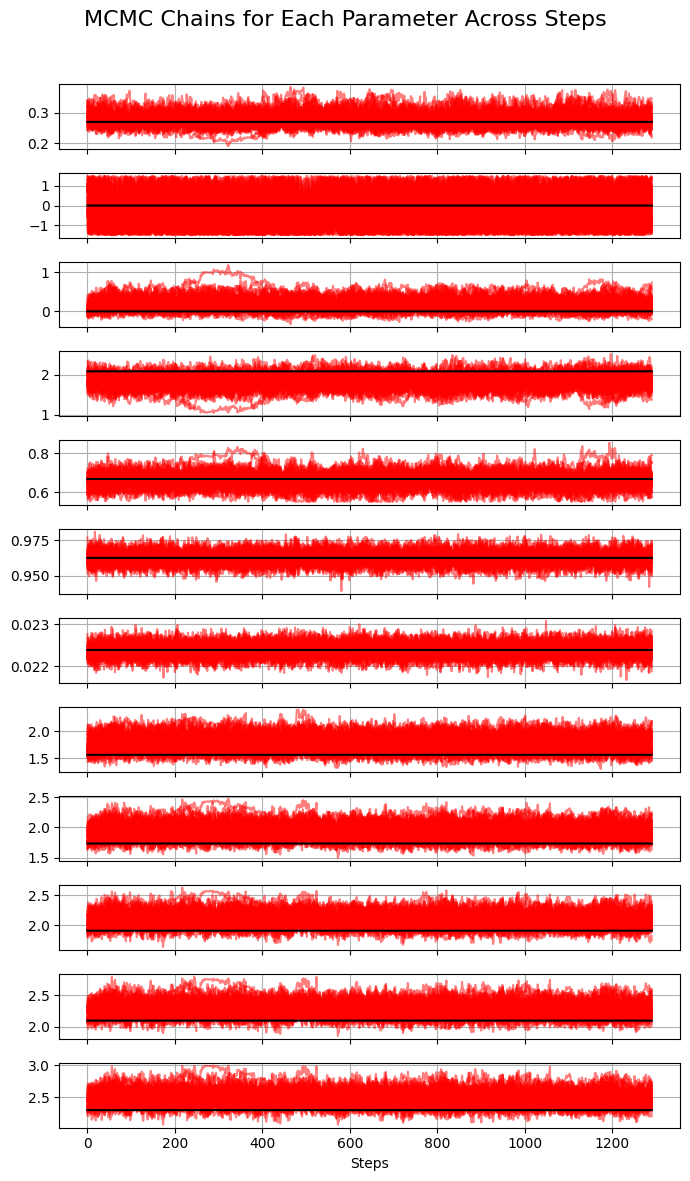

In [497]:
# Assuming `raw_chain` is the MCMC chain you have loaded from the file.
n_steps, n_walkers, n_params = raw_chain_standardcuts.shape

# Create a figure with subplots, one for each parameter
fig, axes = plt.subplots(n_params, figsize=(7, n_params), sharex=True)

# Iterate over each parameter and plot its evolution
for i in range(n_params):
    ax = axes[i]
    for j in range(40): # 22670
        ax.plot(raw_chain_standardcuts[:, j, i], alpha=0.5, color="r")  # Plot for each walker 
    ax.plot(np.arange(len(raw_chain_standardcuts[:, 0, 0])), value1[i]*np.ones(len(raw_chain_standardcuts[:, 0, 0])), color="k")
    
    #ax.set_ylabel(labels[i])
    ax.grid()

# Add a label for the shared x-axis (steps/iterations)
axes[-1].set_xlabel("Steps")

# Set the overall title and adjust layout
plt.suptitle("MCMC Chains for Each Parameter Across Steps", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
#plt.savefig("chains_ESS_noparametrization.pdf", bbox_inches='tight')
plt.show()

In [38]:
for i in range(11):
    mcmc = np.percentile(raw_chain[:, :, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [39]:
for i in range(11):
    mcmc = np.percentile(raw_chain_standardcuts[:, :, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
#11

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[0.269619, 0.0, 0.0, 2.0919999999999996, 0.6688]
[0.2767341794578001, 0.9789619330862238, -0.013269810157927987, 2.007329700851711, 0.6654275733706593]
(193344, 5)
(58748, 5)


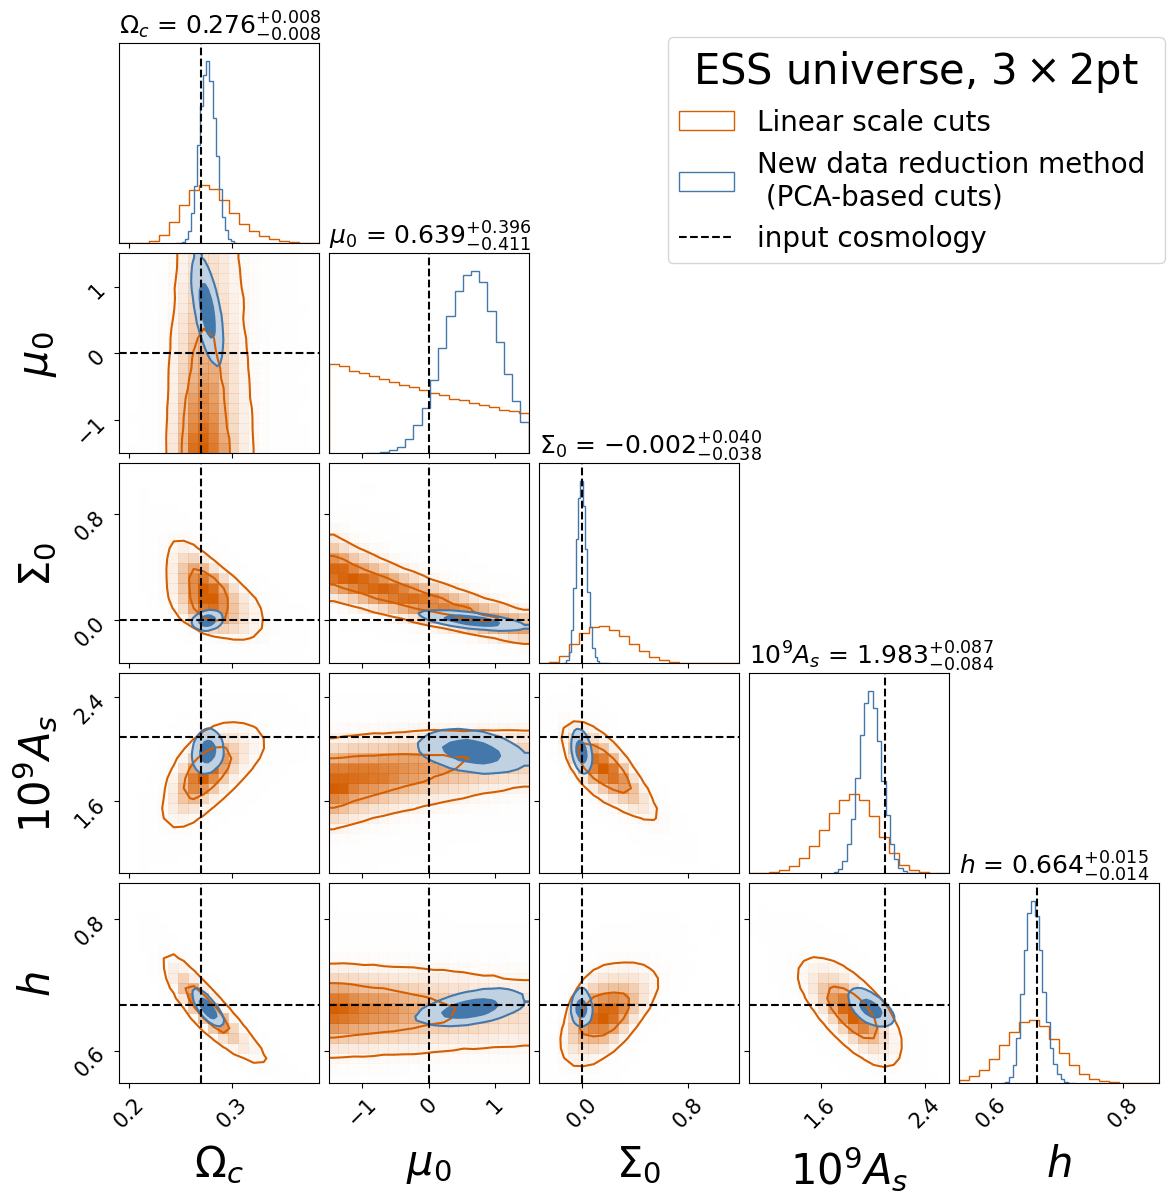

In [41]:
#### STANDARD CUTS #####
print(value1[:ndim])
print(list(max_likelihood_params)[:ndim])
ndim = 5#len(labels)
burned_chain = raw_chain_standardcuts

colors = ["#4477AA",mcolors.to_hex(col[3])]  # Contour colors
truth_color = "k"  # Truth values

CORNER_KWARGS = dict(
    label_kwargs=dict(fontsize=30),
    title_kwargs=dict(fontsize=14.5),
    show_titles=False,
    smooth = 0.5,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    plot_datapoints=False,
    fill_contours=False,
    max_n_ticks=2,
    title_fmt=".3f"
)

flat_samples =  burned_chain.reshape(-1, n_params)[:,:ndim]

print(flat_samples.shape)
len_chain_standardcuts = flat_samples.shape[0]

figure = corner.corner(
    flat_samples, **CORNER_KWARGS, labels=labels, color = colors[1],hist_kwargs=dict(density=True)
);
# COMPUTE STD DIFFERENCE FROM TRUTH
"""
posterior_means = np.mean(flat_samples, axis=0)
posterior_stds = np.std(flat_samples, axis=0)

# Compute Z-score (number of sigmas away from truth values)
sigmas_away = np.abs((value1[:ndim] - posterior_means) / posterior_stds)

# Print the results
print(f"Standard, mu_0: Truth = {value1[1]:.3f}, Mean = {posterior_means[1]:.3f}, "
      f"Std = {posterior_stds[1]:.3f}, Sigma Away = {sigmas_away[1]:.2f}σ")
"""

### PCA CUTS####

burned_chain = raw_chain
flat_samples =  burned_chain.reshape(-1, n_params)[:,:ndim]

CORNER_KWARGS = dict(
    label_kwargs=dict(fontsize=30),
    title_kwargs=dict(fontsize=18, loc="left"),
    show_titles=True,
    smooth = 0.5,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    plot_datapoints=False,
    #quantiles = [0.16, 0.50, 0.84],
    fill_contours=True,
    max_n_ticks=2,
    title_fmt=".3f"
)

print(flat_samples.shape)

corner.corner(
    flat_samples, fig=figure, **CORNER_KWARGS, labels=labels, color=colors[0],hist_kwargs=dict(density=True)
);

# COMPUTE STD DIFFERENCE FROM TRUTH
"""
posterior_means = np.mean(flat_samples, axis=0)
posterior_stds = np.std(flat_samples, axis=0)

# Compute Z-score (number of sigmas away from truth values)
sigmas_away = np.abs((value1[:ndim] - posterior_means) / posterior_stds)

# Print the results
print(f"PCA, mu_0: Truth = {value1[1]:.3f}, Mean = {posterior_means[1]:.3f}, "
      f"Std = {posterior_stds[1]:.3f}, Sigma Away = {sigmas_away[1]:.2f}σ")
print(f"PCA, A_s: Truth = {value1[3]:.3f}, Mean = {posterior_means[3]:.3f}, "
      f"Std = {posterior_stds[3]:.3f}, Sigma Away = {sigmas_away[3]:.2f}σ")
"""

######################
# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    if value1[i] != None:
        ax = axes[i, i]
        ax.axvline(value1[i], color=truth_color, linestyle="--")

# Loop over histograms
for yi in range(ndim):
    for xi in range(yi):
        if value1[xi] == None:
            ax = axes[yi, xi]
            ax.axhline(value1[yi], color=truth_color, linestyle="--")
        elif value1[yi] == None:
            ax = axes[yi, xi]
            ax.axvline(value1[xi], color=truth_color, linestyle="--")
        else:
            ax = axes[yi, xi]
            ax.axvline(value1[xi], color=truth_color, linestyle="--")
            ax.axhline(value1[yi], color=truth_color, linestyle="--")
########################
"""
## Add PCA for parameterized version
CORNER_KWARGS = dict(
    label_kwargs=dict(fontsize=30),
    title_kwargs=dict(fontsize=14.5),
    show_titles=False,
    smooth = False,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    plot_datapoints=False,
    fill_contours=True,
    max_n_ticks=2,
    title_fmt=".4f",
    truths=value1[:ndim],
    truth_color=mcolors.to_hex(col[4])
)

burnin = 0
burned_chain = raw_chain_PCAGRonlycuts[burnin:, :, :]
flat_samples =  burned_chain.reshape(-1, n_params)[:,:ndim]


corner.corner(
    flat_samples, fig=figure, **CORNER_KWARGS, labels=labels, color=mcolors.to_hex(col[2]),hist_kwargs=dict(density=True)
);
"""

for ax in figure.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=15)  # Change label size

#plt.legend(["3x2pt, Existing method (linear scale cuts)","maximum likelihood \n (for PCA-based cuts)","3x2pt, Our method (PCA-based cuts)","input cosmology"],\
#           bbox_to_anchor=(1.0, 12.7), fontsize=40,title=r"ESS universe",title_fontsize=60)
#plt.legend(["Existing method, 3x2pt","maximum likelihood \n (for PCA-based cuts)","PCA method, 3x2pt","input cosmology"], bbox_to_anchor=(1.1, 5.3), fontsize=20,title=r"ESS universe",title_fontsize=30)
plt.legend(["Linear scale cuts","New data reduction method \n (PCA-based cuts)","input cosmology", r"PCA cuts, $\Lambda$-parametrization"], bbox_to_anchor=(1.1, 5.3), fontsize=20,title=r"ESS universe, $3\times2$pt",title_fontsize=30)

#plt.savefig("/home/c2042999/PCA_project/Figures/Final_figures/3x2pt_ESS_mild_marg.pdf", bbox_inches='tight')


[0.269619, 0.0, 0.0, 2.0919999999999996, 0.6688]
[0.2767341794578001, 0.9789619330862238, -0.013269810157927987, 2.007329700851711, 0.6654275733706593]
(193344, 12)
(58748, 12)


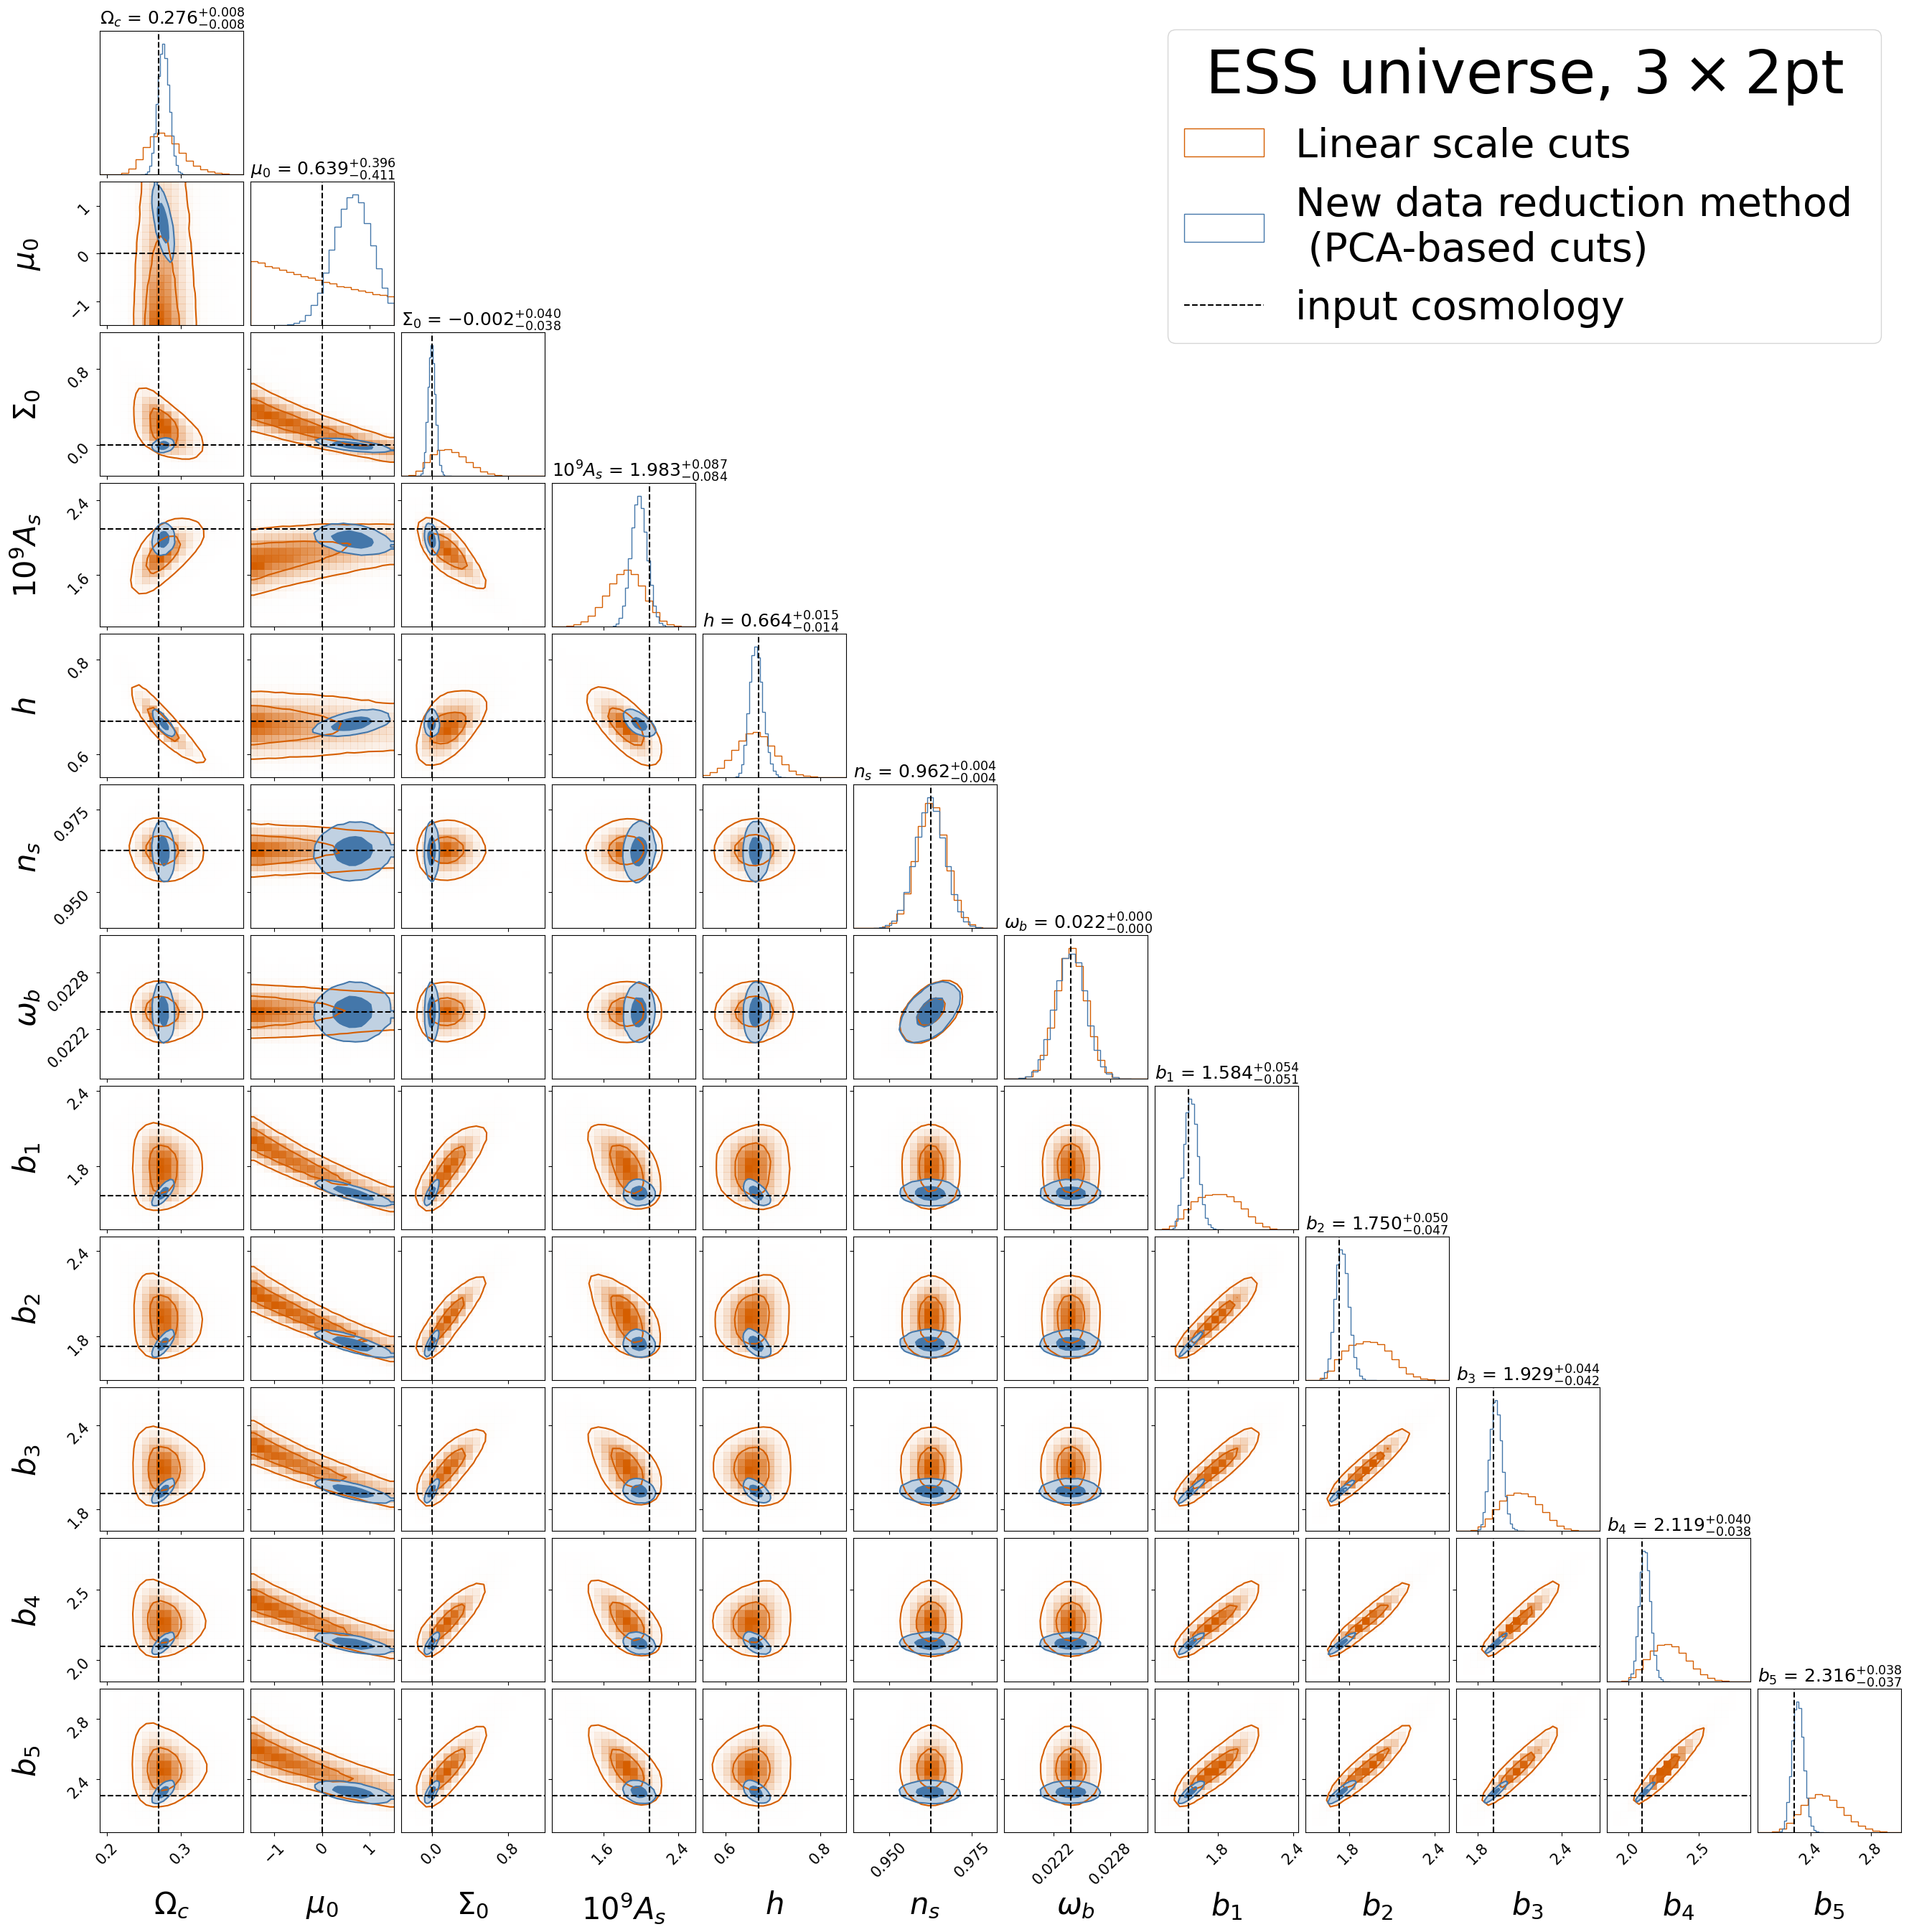

In [42]:
#### STANDARD CUTS #####
print(value1[:ndim])
print(list(max_likelihood_params)[:ndim])
ndim = len(labels)
burned_chain = raw_chain_standardcuts

colors = ["#4477AA",mcolors.to_hex(col[3])]  # Contour colors
truth_color = "k"  # Truth values

CORNER_KWARGS = dict(
    label_kwargs=dict(fontsize=30),
    title_kwargs=dict(fontsize=14.5),
    show_titles=False,
    smooth = 0.5,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    plot_datapoints=False,
    fill_contours=False,
    max_n_ticks=2,
    title_fmt=".3f"
)

flat_samples =  burned_chain.reshape(-1, n_params)[:,:ndim]

print(flat_samples.shape)
len_chain_standardcuts = flat_samples.shape[0]

figure = corner.corner(
    flat_samples, **CORNER_KWARGS, labels=labels, color = colors[1],hist_kwargs=dict(density=True)
);



### PCA CUTS####

burned_chain = raw_chain
flat_samples =  burned_chain.reshape(-1, n_params)[:,:ndim]

CORNER_KWARGS = dict(
    label_kwargs=dict(fontsize=30),
    title_kwargs=dict(fontsize=18, loc="left"),
    show_titles=True,
    smooth = False,
    labelpad = 0.1,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    plot_datapoints=False,
    fill_contours=True,
    max_n_ticks=2,
    title_fmt=".3f"
)

print(flat_samples.shape)

corner.corner(
    flat_samples, fig=figure, **CORNER_KWARGS, labels=labels, color=colors[0],hist_kwargs=dict(density=True)
);

######################
# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    if value1[i] != None:
        ax = axes[i, i]
        ax.axvline(value1[i], color=truth_color, linestyle="--")

# Loop over histograms
for yi in range(ndim):
    for xi in range(yi):
        if value1[xi] == None:
            ax = axes[yi, xi]
            ax.axhline(value1[yi], color=truth_color, linestyle="--")
        elif value1[yi] == None:
            ax = axes[yi, xi]
            ax.axvline(value1[xi], color=truth_color, linestyle="--")
        else:
            ax = axes[yi, xi]
            ax.axvline(value1[xi], color=truth_color, linestyle="--")
            ax.axhline(value1[yi], color=truth_color, linestyle="--")
########################

for ax in figure.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=15)  # Change label size

plt.legend(["Linear scale cuts","New data reduction method \n (PCA-based cuts)","input cosmology"],\
           bbox_to_anchor=(1.0, 12.7), fontsize=40,title=r"ESS universe, $3\times2$pt",title_fontsize=60)

#plt.savefig("/home/c2042999/PCA_project/Figures/Final_figures/3x2pt_ESS_mild.pdf", bbox_inches='tight')


## ESS, with fsigma8

In [6]:
# Read the HDF5 file (note: no need to reset the backend here)
#filename = "/scratch/c2042999/chains/mcmc_ESS_muSigma_PCACuts_nofsigma8_DEparam.h5"
filename = "/scratch/c2042999/chains_final/mcmc_ESS_muSigma_PCACuts_Sigma1_noparam_mild.h5"

while True:
    try:
        reader = emcee.backends.HDFBackend(filename, read_only=True)
        break  # Exit the loop once file is read successfully
    except BlockingIOError:
        # Wait for some time before retrying
        print("File is locked, retrying...")
        time.sleep(0.1)  # Sleep for 1 second before trying again

# Check how many steps have been completed so far
n_steps_completed = reader.iteration
print(f"Number of steps completed: {n_steps_completed}")

# You can also manually access the raw chain and other properties
raw_chain = reader.get_chain(discard=500, thin=20)#discard=800
print(f"Current raw chain shape: {raw_chain.shape}")

tau = reader.get_autocorr_time(tol=0)
max_tau_ratio = np.max(tau * 100 / reader.iteration)
converged = max_tau_ratio < 1
print("Current iteration: {}".format(reader.iteration))
print("Max 100 x Tau/N: {}".format(max_tau_ratio))


Number of steps completed: 14400
Current raw chain shape: (695, 80, 12)
Current iteration: 14400
Max 100 x Tau/N: 0.9997580733328905


In [7]:
# Get the raw chain and log-probabilities
raw_chain = reader.get_chain(flat=False)  # Unflattened chain: (steps, walkers, parameters)
log_prob = reader.get_log_prob(flat=False)  # Unflattened log-probabilities: (steps, walkers)

# Calculate burn-in index
n_burnin = 0  # Adjust if needed

# Remove the burn-in
raw_chain_burnin_removed = raw_chain[n_burnin:]  # Keep steps after burn-in
log_prob_burnin_removed = log_prob[n_burnin:]  # Keep log-probabilities after burn-in

# Flatten the chains after removing burn-in
raw_chain_flat = raw_chain_burnin_removed.reshape(-1, raw_chain.shape[-1])  # (samples, parameters)
log_prob_flat = log_prob_burnin_removed.reshape(-1)  # (samples,)

# Compute the mean of each parameter
mean_params = np.mean(raw_chain_flat, axis=0)

# Find the sample with the maximum log-probability
max_likelihood_index = np.argmax(log_prob_flat)
max_likelihood_params = raw_chain_flat[max_likelihood_index]

# Compute 1σ (68% confidence interval) from the posterior distribution
lower_1sigma, upper_1sigma = np.percentile(raw_chain_flat, [16, 84], axis=0)

print("max likelihood: ", np.max(log_prob_flat))
print("\nMaximum Likelihood Parameter Values (after burn-in):")
print(max_likelihood_params)

print("\n1σ Confidence Intervals (16th-84th percentile) for each parameter:")
for i, (ml_val, lower, upper) in enumerate(zip(max_likelihood_params, lower_1sigma, upper_1sigma)):
    print(f"{labels[i]}: {ml_val:.6f} (+{upper-ml_val:.6f} / -{ml_val-lower:.6f})")


max likelihood:  11.501096601482878

Maximum Likelihood Parameter Values (after burn-in):
[ 0.27673418  0.97896193 -0.01326981  2.0073297   0.66542757  0.96209936
  0.02242671  1.5772761   1.74210739  1.92166226  2.11005836  2.30269841]

1σ Confidence Intervals (16th-84th percentile) for each parameter:
$\Omega_c$: 0.276734 (+0.004709 / -0.007035)
$\mu_0$: 0.978962 (+0.079795 / -0.088353)
$\Sigma_0$: -0.013270 (+0.034566 / -0.022299)
$10^{9}A_s$: 2.007330 (+0.088335 / -0.076278)
$h$: 0.665428 (+0.012496 / -0.011714)
$n_s$: 0.962099 (+0.004773 / -0.003998)
$\omega_b$: 0.022427 (+0.000108 / -0.000205)
$b_1$: 1.577276 (+0.024785 / -0.023482)
$b_2$: 1.742107 (+0.026284 / -0.021071)
$b_3$: 1.921662 (+0.025824 / -0.021315)
$b_4$: 2.110058 (+0.025318 / -0.022393)
$b_5$: 2.302698 (+0.029051 / -0.022081)


In [4]:
"""Get the GR only version"""
#filename = "/scratch/c2042999/chains_final/mcmc_ESS_muSigma_PCACuts_Sigma1_mild.h5"
filename = "mcmc/mcmc_ESS_muSigma_PCACuts_Sigma1_noparam_mild_GRonly.h5"


while True:
    try:
        reader = emcee.backends.HDFBackend(filename, read_only=True)
        break  # Exit the loop once file is read successfully
    except BlockingIOError:
        # Wait for some time before retrying
        print("File is locked, retrying...")
        time.sleep(0.1)  # Sleep for 1 second before trying again

raw_chain_PCAGRonlycuts = reader.get_chain(discard=300)#discard=400, thin=20

# Check how many steps have been completed so far
n_steps_completed = reader.iteration
print(f"Number of steps completed: {n_steps_completed}")

# You can also manually access the raw chain and other properties
print(f"Current raw chain shape: {raw_chain_PCAGRonlycuts.shape}")


tau = reader.get_autocorr_time(tol=0)
max_tau_ratio = np.max(tau * 100 / reader.iteration)
converged = max_tau_ratio < 1
print("Current iteration: {}".format(reader.iteration))
print("Max 100 x Tau/N: {}".format(max_tau_ratio))


Number of steps completed: 11249
Current raw chain shape: (10949, 80, 12)
Current iteration: 11249
Max 100 x Tau/N: 1.2651685866117874


In [5]:
# Get the raw chain and log-probabilities
raw_chain = reader.get_chain(flat=False)  # Unflattened chain: (steps, walkers, parameters)
log_prob = reader.get_log_prob(flat=False)  # Unflattened log-probabilities: (steps, walkers)

# Calculate burn-in index
n_burnin = 0  # Adjust if needed

# Remove the burn-in
raw_chain_burnin_removed = raw_chain[n_burnin:]  # Keep steps after burn-in
log_prob_burnin_removed = log_prob[n_burnin:]  # Keep log-probabilities after burn-in

# Flatten the chains after removing burn-in
raw_chain_flat = raw_chain_burnin_removed.reshape(-1, raw_chain.shape[-1])  # (samples, parameters)
log_prob_flat = log_prob_burnin_removed.reshape(-1)  # (samples,)

# Compute the mean of each parameter
mean_params = np.mean(raw_chain_flat, axis=0)

# Find the sample with the maximum log-probability
max_likelihood_index = np.argmax(log_prob_flat)
max_likelihood_params = raw_chain_flat[max_likelihood_index]

# Compute 1σ (68% confidence interval) from the posterior distribution
lower_1sigma, upper_1sigma = np.percentile(raw_chain_flat, [16, 84], axis=0)

print("max likelihood: ", np.max(log_prob_flat))
print("\nMaximum Likelihood Parameter Values (after burn-in):")
print(max_likelihood_params)

print("\n1σ Confidence Intervals (16th-84th percentile) for each parameter:")
for i, (ml_val, lower, upper) in enumerate(zip(max_likelihood_params, lower_1sigma, upper_1sigma)):
    print(f"{labels[i]}: {ml_val:.6f} (+{upper-ml_val:.6f} / -{ml_val-lower:.6f})")


max likelihood:  9.536158185330667

Maximum Likelihood Parameter Values (after burn-in):
[ 0.27954312  0.91815147 -0.01661681  2.06613571  0.65480889  0.96066264
  0.02234846  1.59150839  1.75188121  1.92614397  2.10558346  2.29638002]

1σ Confidence Intervals (16th-84th percentile) for each parameter:
$\Omega_c$: 0.279543 (+0.005327 / -0.005614)
$\mu_0$: 0.918151 (+0.133238 / -0.029827)
$\Sigma_0$: -0.016617 (+0.028616 / -0.018445)
$10^{9}A_s$: 2.066136 (+0.057205 / -0.071742)
$h$: 0.654809 (+0.007180 / -0.009418)
$n_s$: 0.960663 (+0.005744 / -0.002923)
$\omega_b$: 0.022348 (+0.000178 / -0.000136)
$b_1$: 1.591508 (+0.023089 / -0.013377)
$b_2$: 1.751881 (+0.024637 / -0.014297)
$b_3$: 1.926144 (+0.025921 / -0.015510)
$b_4$: 2.105583 (+0.030004 / -0.014727)
$b_5$: 2.296380 (+0.034089 / -0.015163)


In [430]:
# Assuming `raw_chain` is the MCMC chain you have loaded from the file.
filename = "/scratch/c2042999/chains_final/mcmc_ESS_muSigma_StandardCuts_Sigma1_noparam_mild.h5"

while True:
    try:
        reader = emcee.backends.HDFBackend(filename, read_only=True)
        break  # Exit the loop once file is read successfully
    except BlockingIOError:
        # Wait for some time before retrying
        print("File is locked, retrying...")
        time.sleep(0.1)  # Sleep for 1 second before trying again

raw_chain_standardcuts = reader.get_chain(discard=400, thin=25)#

# Check how many steps have been completed so far
n_steps_completed = reader.iteration
print(f"Number of steps completed: {n_steps_completed}")

# You can also manually access the raw chain and other properties
print(f"Current raw chain shape: {raw_chain_standardcuts.shape}")


tau = reader.get_autocorr_time(tol=0)
max_tau_ratio = np.max(tau * 100 / reader.iteration)
converged = max_tau_ratio < 1
print("Current iteration: {}".format(reader.iteration))
print("Max 100 x Tau/N: {}".format(max_tau_ratio))


Number of steps completed: 33000
Current raw chain shape: (1304, 80, 12)
Current iteration: 33000
Max 100 x Tau/N: 0.99829424816064


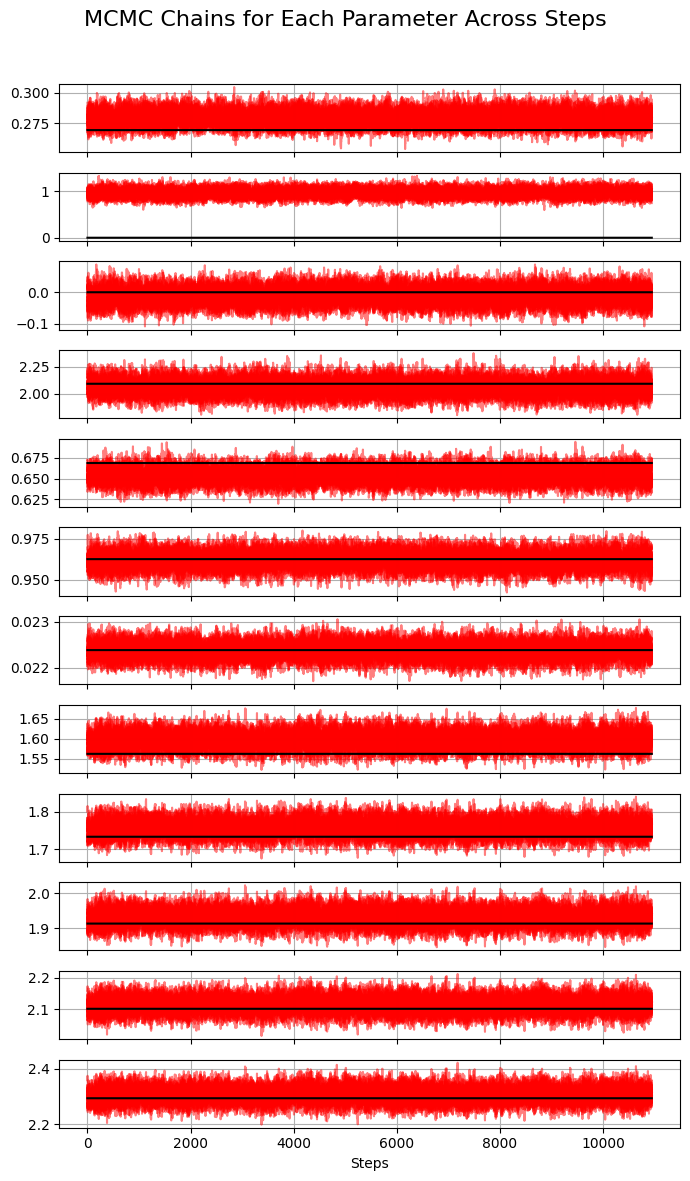

In [14]:
# Assuming `raw_chain` is the MCMC chain you have loaded from the file.
n_steps, n_walkers, n_params = raw_chain.shape

# Create a figure with subplots, one for each parameter
fig, axes = plt.subplots(n_params, figsize=(7, n_params), sharex=True)

# Iterate over each parameter and plot its evolution
for i in range(n_params):
    ax = axes[i]
    for j in range(40):
        ax.plot(raw_chain_PCAGRonlycuts[:, j, i], alpha=0.5, color="r")  # Plot for each walker
        #ax.plot(raw_chain[:, j, i], alpha=0.5, color="r")  # Plot for each walker
        #ax.plot(raw_chain_PCAGRonlycuts[:, j, i], alpha=0.5, color="g")  # Plot for each walker
    ax.plot(np.arange(len(raw_chain_PCAGRonlycuts[:, 0, 0])), value1[i]*np.ones(len(raw_chain_PCAGRonlycuts[:, 0, 0])), color="k")

    """
    ax.plot(np.arange(len(raw_chain_standardcuts[:, 0, 0])), value1[i]*np.ones(len(raw_chain_standardcuts[:, 0, 0])), color="g")
    ax.plot(np.arange(len(raw_chain_standardcuts[:, 0, 0])), lower_value1[i]*np.ones(len(raw_chain_standardcuts[:, 0, 0])), color="g", linestyle="--")
    ax.plot(np.arange(len(raw_chain_standardcuts[:, 0, 0])), upper_value1[i]*np.ones(len(raw_chain_standardcuts[:, 0, 0])), color="g", linestyle="--")
    """
    #ax.set_ylabel(labels[i])
    ax.grid()

# Add a label for the shared x-axis (steps/iterations)
axes[-1].set_xlabel("Steps")

# Set the overall title and adjust layout
plt.suptitle("MCMC Chains for Each Parameter Across Steps", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
#plt.savefig("chains_ESS_noparametrization.pdf", bbox_inches='tight')
plt.show()

In [432]:
for i in range(11):
    mcmc = np.percentile(raw_chain[:, :, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
#11

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [433]:
for i in range(11):
    mcmc = np.percentile(raw_chain_standardcuts[:, :, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

#6

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [10]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.serif": ["CMU Serif", "DejaVu Serif"]
})
col = sns.color_palette("colorblind") 

In [11]:
print(col[0])  # Should output something like (r, g, b) or (r, g, b, a)

(0.00392156862745098, 0.45098039215686275, 0.6980392156862745)


[0.269619, 0.0, 0.0, 2.0919999999999996, 0.6688]
[0.2767341794578001, 0.9789619330862238, -0.013269810157927987, 2.007329700851711, 0.6654275733706593]
(104320, 5)
mu_0: Truth = 0.000, Mean = 1.040, Std = 0.167, Sigma Away = 6.23σ
(1152000, 5)
param: Truth = 0.270, Mean = 0.276, Std = 0.006, Sigma Away = 1.02σ
param: Truth = 0.000, Mean = 0.975, Std = 0.085, Sigma Away = 11.52σ
param: Truth = 0.000, Mean = -0.007, Std = 0.029, Sigma Away = 0.24σ
param: Truth = 2.092, Mean = 2.013, Std = 0.083, Sigma Away = 0.95σ
param: Truth = 0.669, Mean = 0.666, Std = 0.012, Sigma Away = 0.24σ


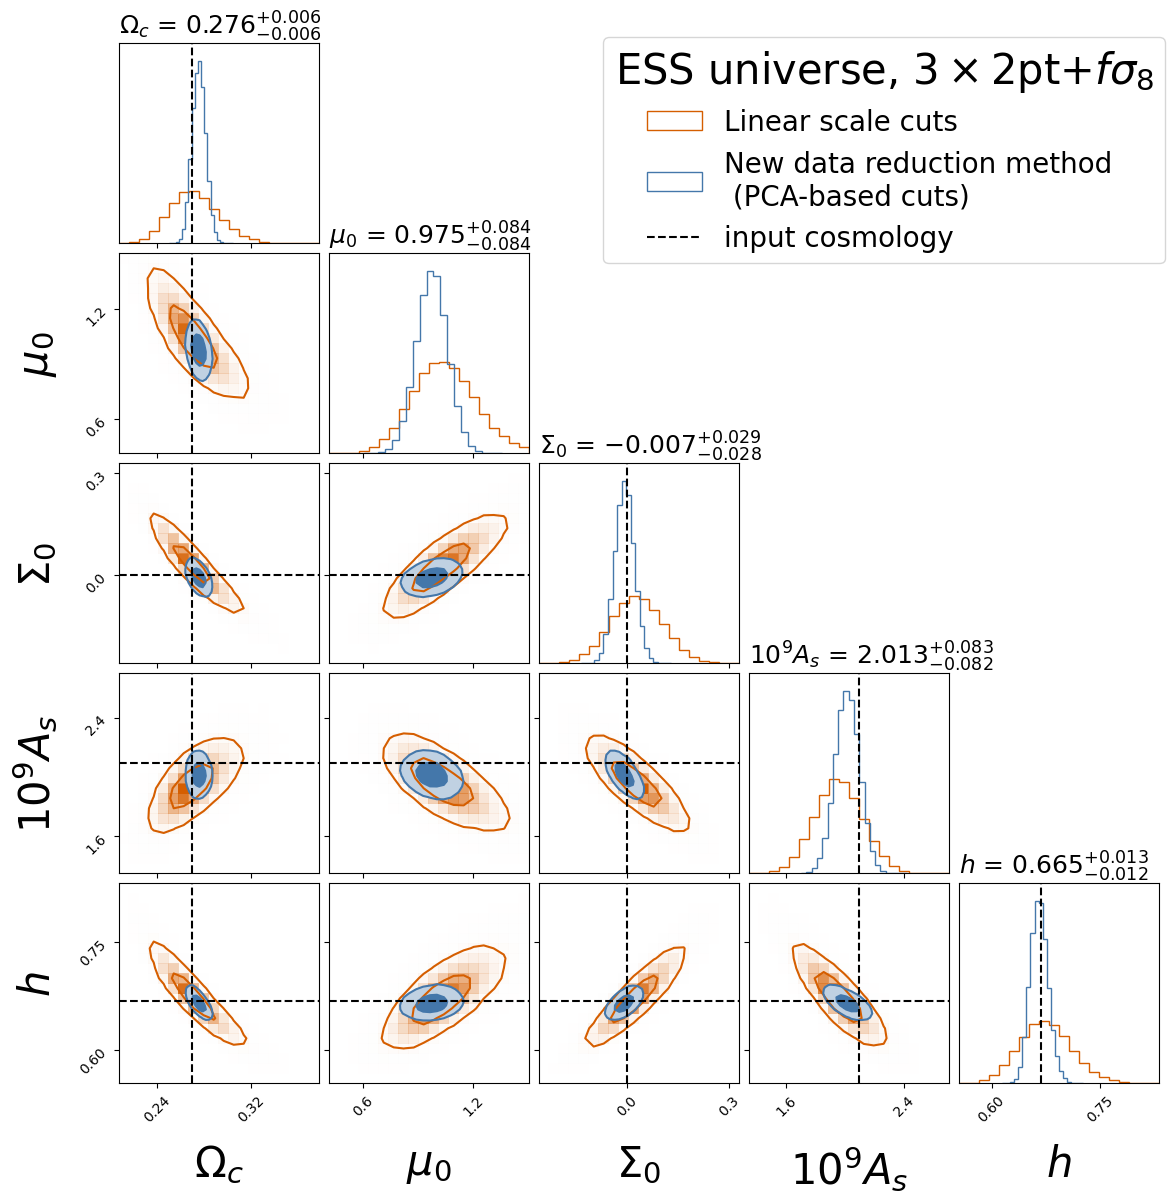

In [443]:
#### STANDARD CUTS #####

print(value1[:ndim])
print(list(max_likelihood_params)[:ndim])
ndim = 5#len(labels)
burned_chain = raw_chain_standardcuts

colors = ["#4477AA",mcolors.to_hex(col[3])]  # Contour colors
truth_color = "k"  # Truth values

CORNER_KWARGS = dict(
    label_kwargs=dict(fontsize=30),
    title_kwargs=dict(fontsize=14.5),
    show_titles=False,
    smooth = False,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    plot_datapoints=False,
    fill_contours=False,
    max_n_ticks=2,
    title_fmt=".3f"
)

flat_samples =  burned_chain.reshape(-1, n_params)[:,:ndim]

print(flat_samples.shape)
len_chain_standardcuts = flat_samples.shape[0]

figure = corner.corner(
    flat_samples, **CORNER_KWARGS, labels=labels, color = colors[1],hist_kwargs=dict(density=True)
);
"""
"""
# COMPUTE STD DIFFERENCE FROM TRUTH
posterior_means = np.mean(flat_samples, axis=0)
posterior_stds = np.std(flat_samples, axis=0)

# Compute Z-score (number of sigmas away from truth values)
sigmas_away = np.abs((value1[:ndim] - posterior_means) / posterior_stds)

# Print the results
print(f"mu_0: Truth = {value1[1]:.3f}, Mean = {posterior_means[1]:.3f}, "
      f"Std = {posterior_stds[1]:.3f}, Sigma Away = {sigmas_away[1]:.2f}σ")


### PCA CUTS####

burned_chain = raw_chain
flat_samples =  burned_chain.reshape(-1, n_params)[:,:ndim]

CORNER_KWARGS = dict(
    label_kwargs=dict(fontsize=30),
    title_kwargs=dict(fontsize=18, loc="left"),
    show_titles=True,
    smooth = False,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    plot_datapoints=False,
    fill_contours=True,
    max_n_ticks=2,
    title_fmt=".3f"
)

print(flat_samples.shape)

figure = corner.corner(
    flat_samples,fig=figure, **CORNER_KWARGS, labels=labels, color=colors[0],hist_kwargs=dict(density=True)
);

# COMPUTE STD DIFFERENCE FROM TRUTH
posterior_means = np.mean(flat_samples, axis=0)
posterior_stds = np.std(flat_samples, axis=0)

# Compute Z-score (number of sigmas away from truth values)
sigmas_away = np.abs((value1[:ndim] - posterior_means) / posterior_stds)

# Print the results
for i in range(ndim):
    print(f"param: Truth = {value1[i]:.3f}, Mean = {posterior_means[i]:.3f}, "
          f"Std = {posterior_stds[i]:.3f}, Sigma Away = {sigmas_away[i]:.2f}σ")


## Add PCA for parameterized version
"""
CORNER_KWARGS = dict(
    label_kwargs=dict(fontsize=30),
    title_kwargs=dict(fontsize=14.5),
    show_titles=False,
    smooth = 0.5,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    plot_datapoints=False,
    fill_contours=True,
    max_n_ticks=2,
    title_fmt=".4f"
)

burnin = 0
burned_chain = raw_chain_PCAGRonlycuts[burnin:, :, :]
flat_samples =  burned_chain.reshape(-1, n_params)[:,:ndim]

corner.corner(
    flat_samples, fig=figure, **CORNER_KWARGS, labels=labels, color=mcolors.to_hex(col[2]),hist_kwargs=dict(density=True)
);

# COMPUTE STD DIFFERENCE FROM TRUTH
posterior_means = np.mean(flat_samples, axis=0)
posterior_stds = np.std(flat_samples, axis=0)

# Compute Z-score (number of sigmas away from truth values)
sigmas_away = np.abs((value1[:ndim] - posterior_means) / posterior_stds)

# Print the results
for i in range(ndim):
    print(f"param: Truth = {value1[i]:.3f}, Mean = {posterior_means[i]:.3f}, "
          f"Std = {posterior_stds[i]:.3f}, Sigma Away = {sigmas_away[i]:.2f}σ")


for ax in figure.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=15)  # Change label size
"""
######################
# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    if value1[i] != None:
        ax = axes[i, i]
        ax.axvline(value1[i], color=truth_color, linestyle="--")

# Loop over histograms
for yi in range(ndim):
    for xi in range(yi):
        if value1[xi] == None:
            ax = axes[yi, xi]
            ax.axhline(value1[yi], color=truth_color, linestyle="--")
        elif value1[yi] == None:
            ax = axes[yi, xi]
            ax.axvline(value1[xi], color=truth_color, linestyle="--")
        else:
            ax = axes[yi, xi]
            ax.axvline(value1[xi], color=truth_color, linestyle="--")
            ax.axhline(value1[yi], color=truth_color, linestyle="--")
####################



plt.legend(["Linear scale cuts","New data reduction method \n (PCA-based cuts)","input cosmology", r"PCA cuts, $\Lambda$-parametrization"], bbox_to_anchor=(1.1, 5.3), fontsize=20,title=r"ESS universe, $3\times2$pt$+f\sigma_8$",title_fontsize=30)

#plt.legend([r"PCA cuts, ESS-specific parametrization",r"PCA cuts, $\Lambda$-parametrization","input cosmology"], bbox_to_anchor=(1.2, 5.3), fontsize=20,title=r"ESS universe, $3\times2$pt$+f\sigma_8$",title_fontsize=30)

#plt.savefig("/home/c2042999/PCA_project/Figures/Final_figures/3x2pt_fs8_ESS_mild_marg.pdf", bbox_inches='tight')


[0.269619, None, 0.0, 2.0919999999999996, 0.6688]
[0.2767341794578001, 0.9789619330862238, -0.013269810157927987, 2.007329700851711, 0.6654275733706593]
(67640, 12)
(1152000, 12)


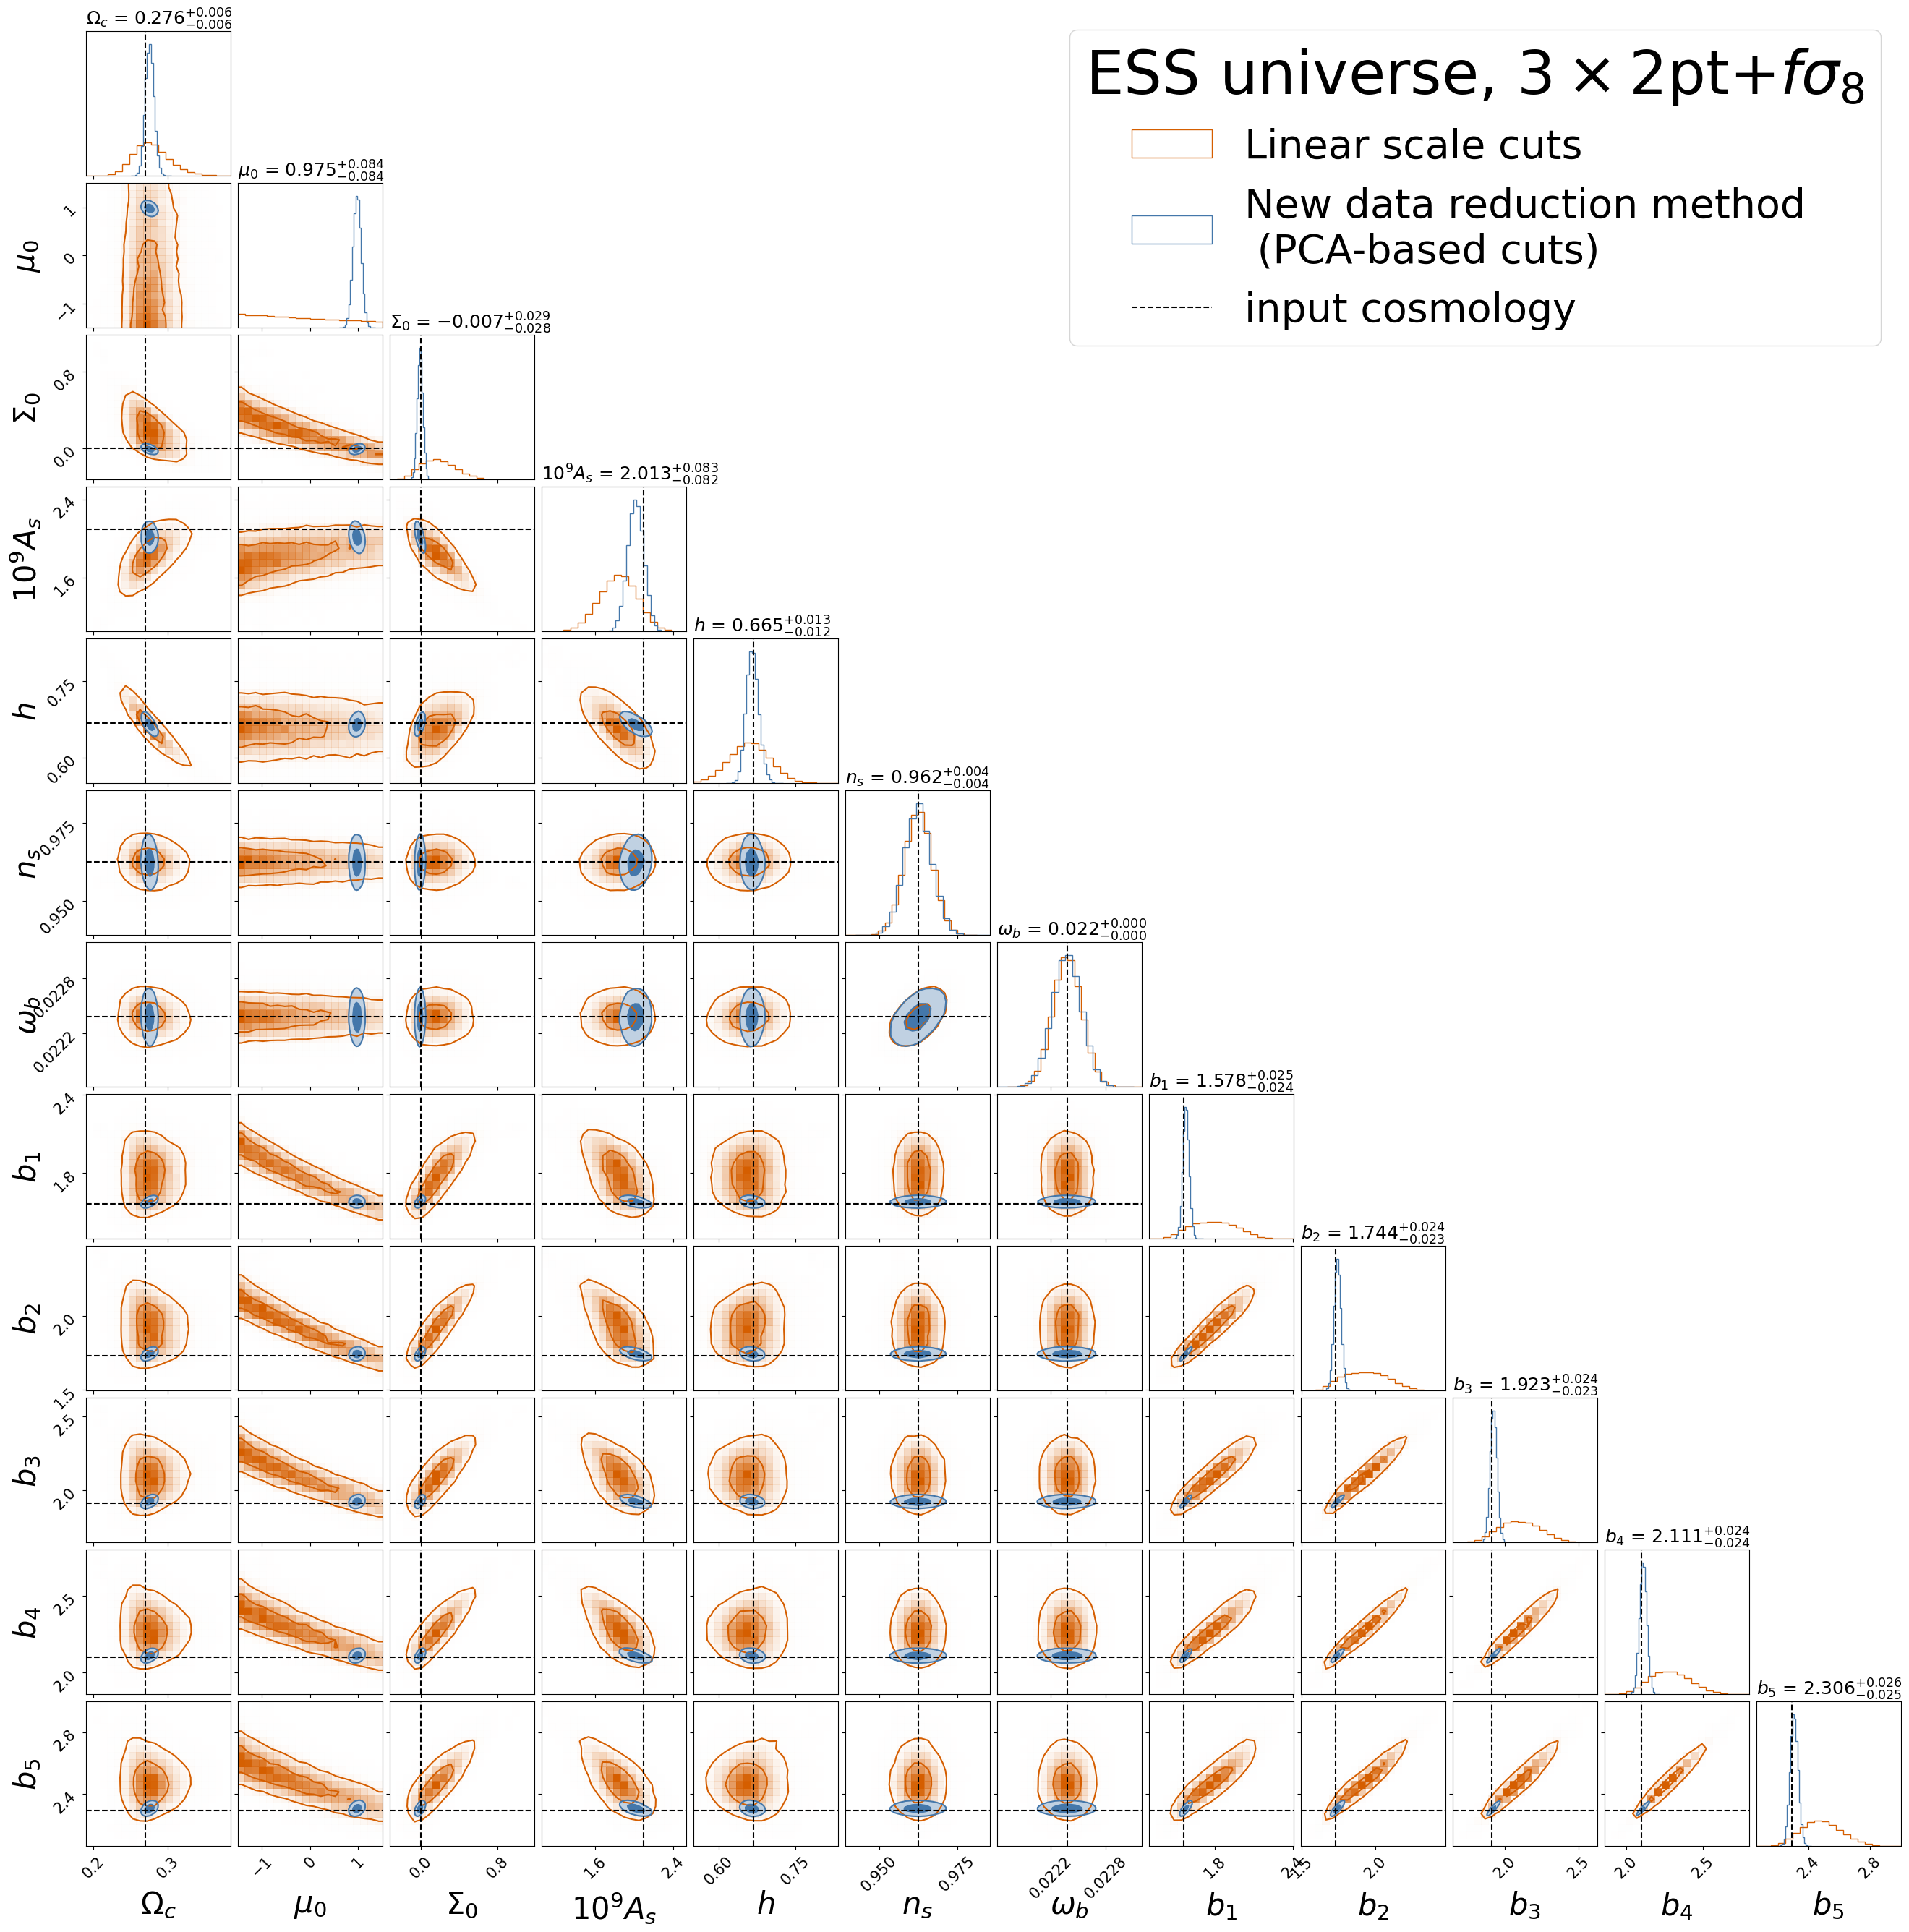

In [344]:
#### STANDARD CUTS #####
print(value1[:ndim])
print(list(max_likelihood_params)[:ndim])
ndim = len(labels)
burned_chain = raw_chain_standardcuts

colors = ["#4477AA",mcolors.to_hex(col[3])]  # Contour colors
truth_color = "k"  # Truth values

CORNER_KWARGS = dict(
    label_kwargs=dict(fontsize=30),
    title_kwargs=dict(fontsize=14.5),
    show_titles=False,
    smooth = False,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    plot_datapoints=False,
    fill_contours=False,
    max_n_ticks=2,
    title_fmt=".3f"
)

flat_samples =  burned_chain.reshape(-1, n_params)[:,:ndim]

print(flat_samples.shape)
len_chain_standardcuts = flat_samples.shape[0]

figure = corner.corner(
    flat_samples, **CORNER_KWARGS, labels=labels, color = colors[1],hist_kwargs=dict(density=True)
);

### PCA CUTS####

burned_chain = raw_chain
flat_samples =  burned_chain.reshape(-1, n_params)[:,:ndim]

CORNER_KWARGS = dict(
    label_kwargs=dict(fontsize=30),
    title_kwargs=dict(fontsize=18, loc="left"),
    show_titles=True,
    smooth = False,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    plot_datapoints=False,
    fill_contours=True,
    max_n_ticks=2,
    title_fmt=".3f"
)

print(flat_samples.shape)

corner.corner(
    flat_samples, fig=figure, **CORNER_KWARGS, labels=labels, color=colors[0],hist_kwargs=dict(density=True)
);


######################
# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    if value1[i] != None:
        ax = axes[i, i]
        ax.axvline(value1[i], color=truth_color, linestyle="--")

# Loop over histograms
for yi in range(ndim):
    for xi in range(yi):
        if value1[xi] == None:
            ax = axes[yi, xi]
            ax.axhline(value1[yi], color=truth_color, linestyle="--")
        elif value1[yi] == None:
            ax = axes[yi, xi]
            ax.axvline(value1[xi], color=truth_color, linestyle="--")
        else:
            ax = axes[yi, xi]
            ax.axvline(value1[xi], color=truth_color, linestyle="--")
            ax.axhline(value1[yi], color=truth_color, linestyle="--")
########################
"""
## Add PCA for parameterized version
CORNER_KWARGS = dict(
    label_kwargs=dict(fontsize=30),
    title_kwargs=dict(fontsize=14.5),
    show_titles=False,
    smooth = False,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    plot_datapoints=False,
    fill_contours=True,
    max_n_ticks=2,
    title_fmt=".4f",
    truths=value1[:ndim],
    truth_color=mcolors.to_hex(col[4])
)

burnin = 0
burned_chain = raw_chain_PCAGRonlycuts[burnin:, :, :]
flat_samples =  burned_chain.reshape(-1, n_params)[:,:ndim]


corner.corner(
    flat_samples, fig=figure, **CORNER_KWARGS, labels=labels, color=mcolors.to_hex(col[2]),hist_kwargs=dict(density=True)
);
"""
for ax in figure.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=15)  # Change label size
 
plt.legend(["Linear scale cuts","New data reduction method \n (PCA-based cuts)","input cosmology", r"PCA cuts, $\Lambda$-parametrization"],\
           bbox_to_anchor=(1.0, 12.7), fontsize=40,title=r"ESS universe, $3\times2$pt$+f\sigma_8$",title_fontsize=60)
#plt.legend(["Linear scale cuts","New data reduction method \n (PCA-based cuts)","input cosmology", r"PCA cuts, $\Lambda$-parametrization"], bbox_to_anchor=(1.1, 5.3), fontsize=20,title=r"ESS universe",title_fontsize=30)

#plt.savefig("/home/c2042999/PCA_project/Figures/Final_figures/3x2pt_fs8_ESS_mild.pdf", bbox_inches='tight')


(1152000, 5)
mu_0: Truth = 0.000, Mean = 0.975, Std = 0.085, Sigma Away = 11.52σ
param: Truth = 0.270, Mean = 0.280, Std = 0.005, Sigma Away = 1.83σ
param: Truth = 0.000, Mean = 0.970, Std = 0.083, Sigma Away = 11.69σ
param: Truth = 0.000, Mean = -0.012, Std = 0.024, Sigma Away = 0.49σ
param: Truth = 2.092, Mean = 2.059, Std = 0.065, Sigma Away = 0.51σ
param: Truth = 0.669, Mean = 0.654, Std = 0.008, Sigma Away = 1.85σ


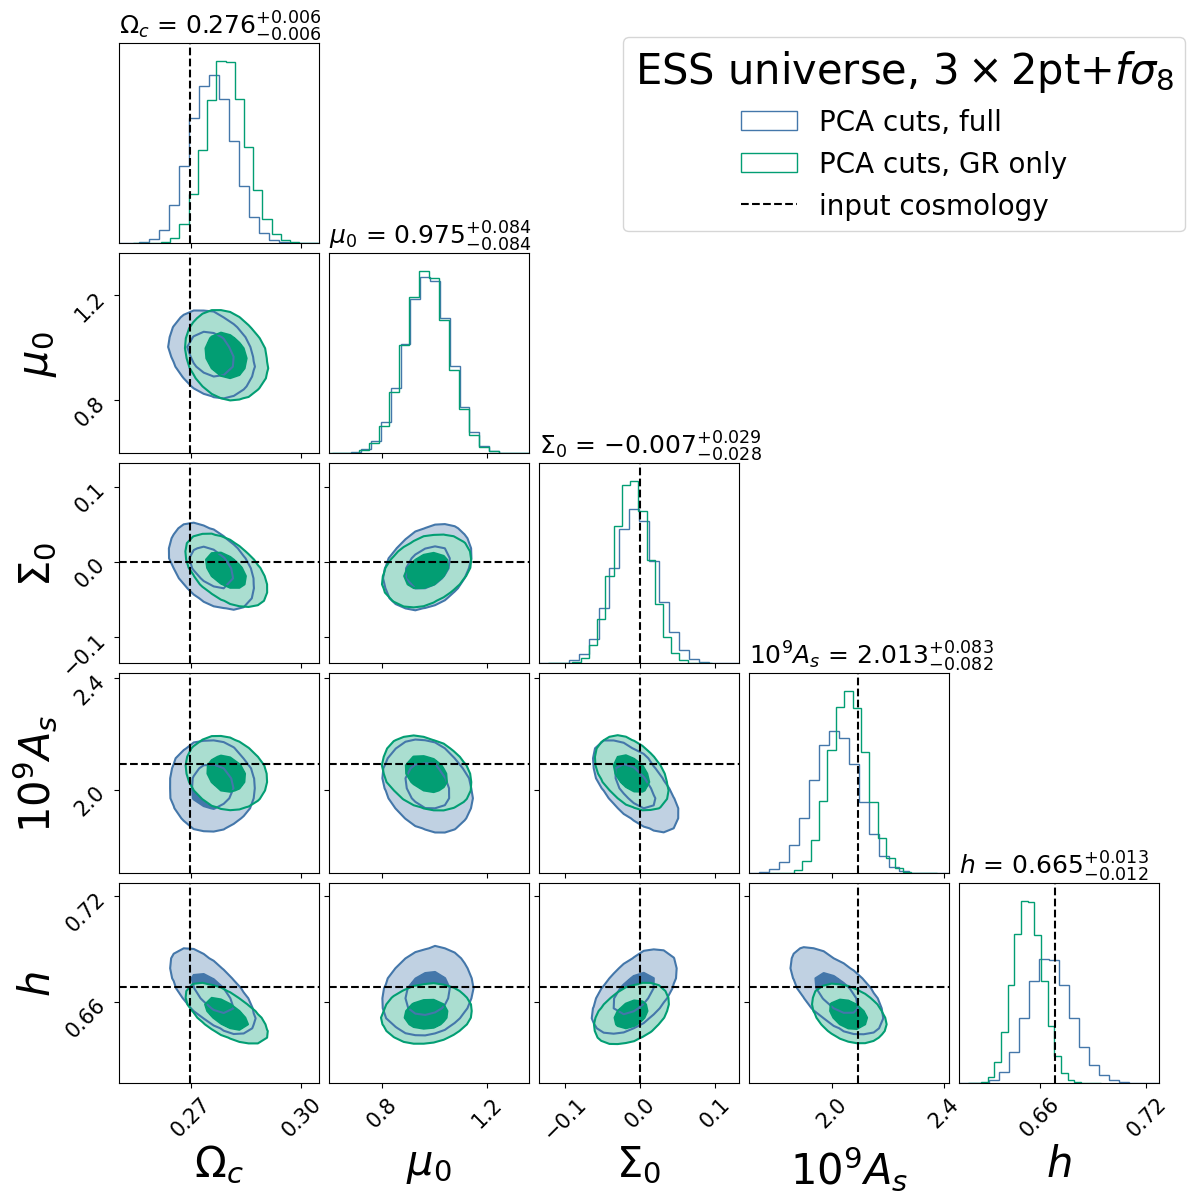

In [17]:
#### STANDARD CUTS #####
colors = ["#4477AA",mcolors.to_hex(col[3])]  # Contour colors
truth_color = "k"  # Truth values
"""
print(value1[:ndim])
print(list(max_likelihood_params)[:ndim])
burned_chain = raw_chain_standardcuts

colors = ["#4477AA",mcolors.to_hex(col[3])]  # Contour colors
truth_color = "k"  # Truth values

CORNER_KWARGS = dict(
    label_kwargs=dict(fontsize=30),
    title_kwargs=dict(fontsize=14.5),
    show_titles=False,
    smooth = False,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    plot_datapoints=False,
    fill_contours=False,
    max_n_ticks=2,
    title_fmt=".3f"
)

flat_samples =  burned_chain.reshape(-1, n_params)[:,:ndim]

print(flat_samples.shape)
len_chain_standardcuts = flat_samples.shape[0]

figure = corner.corner(
    flat_samples, **CORNER_KWARGS, labels=labels, color = colors[1],hist_kwargs=dict(density=True)
);
"""
"""
# COMPUTE STD DIFFERENCE FROM TRUTH
posterior_means = np.mean(flat_samples, axis=0)
posterior_stds = np.std(flat_samples, axis=0)

# Compute Z-score (number of sigmas away from truth values)
sigmas_away = np.abs((value1[:ndim] - posterior_means) / posterior_stds)

# Print the results
print(f"mu_0: Truth = {value1[1]:.3f}, Mean = {posterior_means[1]:.3f}, "
      f"Std = {posterior_stds[1]:.3f}, Sigma Away = {sigmas_away[1]:.2f}σ")
"""
ndim = 5#len(labels)

### PCA CUTS####

burned_chain = raw_chain
flat_samples =  burned_chain.reshape(-1, n_params)[:,:ndim]

CORNER_KWARGS = dict(
    label_kwargs=dict(fontsize=30),
    title_kwargs=dict(fontsize=18, loc="left"),
    show_titles=True,
    smooth = False,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    plot_datapoints=False,
    fill_contours=True,
    max_n_ticks=2,
    title_fmt=".3f"
)

print(flat_samples.shape)

figure = corner.corner(
    flat_samples, **CORNER_KWARGS, labels=labels, color=colors[0],hist_kwargs=dict(density=True)
);

# COMPUTE STD DIFFERENCE FROM TRUTH
posterior_means = np.mean(flat_samples, axis=0)
posterior_stds = np.std(flat_samples, axis=0)

# Compute Z-score (number of sigmas away from truth values)
sigmas_away = np.abs((value1[:ndim] - posterior_means) / posterior_stds)

# Print the results
print(f"mu_0: Truth = {value1[1]:.3f}, Mean = {posterior_means[1]:.3f}, "
      f"Std = {posterior_stds[1]:.3f}, Sigma Away = {sigmas_away[1]:.2f}σ")


## Add PCA for parameterized version

CORNER_KWARGS = dict(
    label_kwargs=dict(fontsize=30),
    title_kwargs=dict(fontsize=14.5),
    show_titles=False,
    smooth = 0.5,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    plot_datapoints=False,
    fill_contours=True,
    max_n_ticks=2,
    title_fmt=".4f"
)

burnin = 0
burned_chain = raw_chain_PCAGRonlycuts[burnin:, :, :]
flat_samples =  burned_chain.reshape(-1, n_params)[:,:ndim]

corner.corner(
    flat_samples, fig=figure, **CORNER_KWARGS, labels=labels, color=mcolors.to_hex(col[2]),hist_kwargs=dict(density=True)
);

# COMPUTE STD DIFFERENCE FROM TRUTH
posterior_means = np.mean(flat_samples, axis=0)
posterior_stds = np.std(flat_samples, axis=0)

# Compute Z-score (number of sigmas away from truth values)
sigmas_away = np.abs((value1[:ndim] - posterior_means) / posterior_stds)

# Print the results
for i in range(ndim):
    print(f"param: Truth = {value1[i]:.3f}, Mean = {posterior_means[i]:.3f}, "
          f"Std = {posterior_stds[i]:.3f}, Sigma Away = {sigmas_away[i]:.2f}σ")


for ax in figure.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=15)  # Change label size

######################
# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    if value1[i] != None:
        ax = axes[i, i]
        ax.axvline(value1[i], color=truth_color, linestyle="--")

# Loop over histograms
for yi in range(ndim):
    for xi in range(yi):
        if value1[xi] == None:
            ax = axes[yi, xi]
            ax.axhline(value1[yi], color=truth_color, linestyle="--")
        elif value1[yi] == None:
            ax = axes[yi, xi]
            ax.axvline(value1[xi], color=truth_color, linestyle="--")
        else:
            ax = axes[yi, xi]
            ax.axvline(value1[xi], color=truth_color, linestyle="--")
            ax.axhline(value1[yi], color=truth_color, linestyle="--")
######################



#plt.legend(["Linear scale cuts","New data reduction method \n (PCA-based cuts)","input cosmology", r"PCA cuts, $\Lambda$-parametrization"], bbox_to_anchor=(1.1, 5.3), fontsize=20,title=r"ESS universe, $3\times2$pt$+f\sigma_8$",title_fontsize=30)

#plt.legend([r"PCA cuts, ESS-specific parametrization",r"PCA cuts, $\Lambda$-parametrization","input cosmology"], bbox_to_anchor=(1.2, 5.3), fontsize=20,title=r"ESS universe, $3\times2$pt$+f\sigma_8$",title_fontsize=30)
plt.legend([r"PCA cuts, full",r"PCA cuts, GR only","input cosmology"], bbox_to_anchor=(1.2, 5.3), fontsize=20,title=r"ESS universe, $3\times2$pt$+f\sigma_8$",title_fontsize=30)

#plt.savefig("/home/c2042999/PCA_project/Figures/Final_figures/3x2pt_fs8_ESS_mild_marg_GRonly.pdf", bbox_inches='tight')


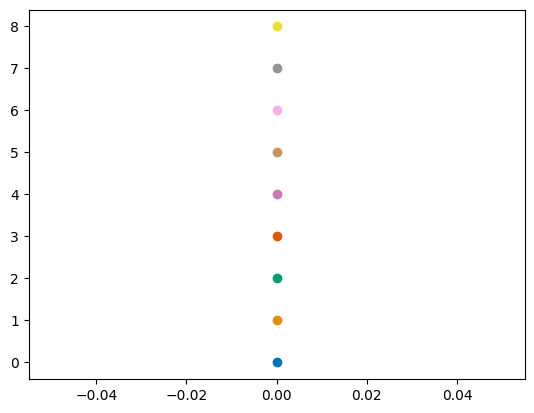

In [379]:
for i in range(9):
    plt.scatter(0,i,color=mcolors.to_hex(col[i]))


## WAIC criterion

In [43]:
import h5py

In [46]:
# Load the MCMC samples and log-likelihoods
def load_mcmc_data(filename):
    with h5py.File(filename, 'r') as f:
        samples = f['mcmc']['chain'][...]      # shape: (n_walkers, n_steps, n_params)
        log_likelihood = f['mcmc']['log_prob'][...]  # shape: (n_walkers, n_steps)
    return samples, log_likelihood

# Files for both models
file_model_1 = '/scratch/c2042999/chains/mcmc_ESS_muSigma_PCACuts_noparam.h5'
file_model_2 = '/scratch/c2042999/chains/mcmc_ESS_muSigma_StandardCuts_noparam.h5'

samples_1, log_likelihood_1 = load_mcmc_data(file_model_1)
samples_2, log_likelihood_2 = load_mcmc_data(file_model_2)

In [47]:
def compute_waic(log_likelihood):
    # Reshape to (n_samples, n_data) if needed
    log_likelihood = log_likelihood.reshape(-1, log_likelihood.shape[-1])

    # Log Pointwise Predictive Density (lppd)
    lppd = np.sum(np.log(np.mean(np.exp(log_likelihood), axis=0)))

    # Effective number of parameters (p_WAIC)
    p_waic = np.sum(np.var(log_likelihood, axis=0))

    # WAIC Calculation
    waic = -2 * (lppd - p_waic)
    return waic

# WAIC for both models
waic_model_1 = compute_waic(log_likelihood_1)
waic_model_2 = compute_waic(log_likelihood_2)

# Display the results
print(f"WAIC for Model 1 (PCA Cuts): {waic_model_1}")
print(f"WAIC for Model 2 (Standard Cuts): {waic_model_2}")

WAIC for Model 1 (PCA Cuts): 14892.2541258095
WAIC for Model 2 (Standard Cuts): 4487.198990053972


In [48]:
def waic_se(log_likelihood):
    log_likelihood = log_likelihood.reshape(-1, log_likelihood.shape[-1])
    return np.sqrt(len(log_likelihood[0]) * np.var(np.var(log_likelihood, axis=0)))

se_model_1 = waic_se(log_likelihood_1)
se_model_2 = waic_se(log_likelihood_2)

delta_waic = waic_model_1 - waic_model_2
se_delta = np.sqrt(se_model_1**2 + se_model_2**2)

print(f"ΔWAIC = {delta_waic} ± {se_delta}")

ΔWAIC = 10405.055135755529 ± 406.0781495587649
